# Supplementary figure: change in static stability in CRH-only simulations with respect to the radiation-off simulations for the simulations with free-tropospheric cloud-radiative heating and boundary-layer cloud-radiative heating 

Based on figure 4 of the main text.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys; sys.path.append("../helperfuncs")
from myfunctions import dict_expid, zlevels, load_data, domainmean_per_level, make_meancyclone

Load CRH only and radiation-off simulations.

In [2]:
explist=list()
for expid in dict_expid.keys():
    if "NORAD" in dict_expid[expid] or "CRHONLY" in dict_expid[expid]: # select simulations with no radiation or cloud-radiative heating only
        explist.append(load_data(expid=expid, chunks="auto"))

Add potential temperature to datasets.

In [3]:
def compute_theta(ds):
    ds = ds[["pres","temp"]].sel(lat=slice(80,20)).squeeze()
    theta = (ds["temp"]*np.power(1.e5/ds["pres"], 287./1005.)).compute()
    return xr.DataArray( theta, dims = ds["temp"].dims, 
                         coords= ds["temp"].coords )

for exp in explist:
    exp["theta"] = compute_theta(exp)

Add static stability to datasets.

In [4]:
def compute_drystability(ds):
    # note: we use the hard fact that height is the 2nd dimension
    drystability = np.gradient(ds["theta"].values, zlevels(), axis=1)
    # return as dataarray
    return xr.DataArray( drystability, dims = ds["temp"].dims, 
                         coords= ds["temp"].coords )

for exp in explist:
    exp["stab"] = compute_drystability(exp)

Function to average an atmospheric variable over regions of upward and downward motion.

In [5]:
def mean_variable_up_dn_w5km(ds, var):
    """Compute mean of an atmospheric variable such as temperature and cloud-radiative heating over regions of upward and downward motion.
    
    The variable <var> is assumed to be part of the input dataset.
    Up- and downward motion are defined based on the vertical velocity at 5km."""
    ds = ds.sel(lat=slice(60,40)).squeeze()
    # ascent
    weights = xr.where(ds["w5km"]<-1e-10, 1.0, 0.0).squeeze() * ds["rho"] * np.cos(np.deg2rad(ds.lat))
    var_weighted = ds[var].weighted(weights)
    var_up = var_weighted.mean(["lat", "lon"])
    # descent
    weights = xr.where(ds["w5km"]>1e-10, 1.0, 0.0).squeeze() * ds["rho"] * np.cos(np.deg2rad(ds.lat))
    var_weighted = ds[var].weighted(weights)
    var_dn = var_weighted.mean(["lat", "lon"])
    return var_up, var_dn

Plotting.

In [6]:
def make_niceaxes(ax, ticklength=0.1):
    # adjust spines
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.spines["bottom"].set_position(("data",0))
    #ax.spines["left"].set_position(("data",0))
    ax.spines["left"].set_color("none")
    plt.ylim(0,14)
    plt.yticks([0,2,4,6,8,10,12,14], ["0", "2", "4", "6", "8", "10", "12", "14"], fontsize=10)   
    plt.plot([0,0], [0,14], linewidth=0.7, color="k", zorder=-10)
    for ypos in [2,4,6,8,10,12,14]:
        plt.plot([-0.5*ticklength,0.5*ticklength], [ypos,ypos], linewidth=0.7, color="k", zorder=-10)

In [7]:
def make_heightplot_var_up_diff2norad_w5km(var, setup1, setup2, timeslice, color, linestyle="-"):
    ds1 = [ds for ds in explist if ds.attrs["setup"]==setup1][0]
    ds2 = [ds for ds in explist if ds.attrs["setup"]==setup2][0]
    var_up1, var_dn1 =  mean_variable_up_dn_w5km(ds1.isel(time=slice(timeslice[0], timeslice[1])), var)
    var_up2, var_dn2 =  mean_variable_up_dn_w5km(ds2.isel(time=slice(timeslice[0], timeslice[1])), var)
    z = zlevels()
    dvar_up = var_up1.mean("time") - var_up2.mean("time")
    if var == "stab":
        dvar_up[np.abs(dvar_up)>=2]=np.nan
    plt.plot(dvar_up, zlevels(), color=color, linestyle=linestyle)
    
def make_heightplot_var_up_w5km(var, setup, timeslice, color, linestyle="-"):
    ds = [ds for ds in explist if ds.attrs["setup"]==setup][0]
    var_up, var_dn =  mean_variable_up_dn_w5km(ds.isel(time=slice(timeslice[0], timeslice[1])), var)
    z = zlevels()
    if "ICON2.6 CRHONLY":
        var_up[:,89:]=np.nan
    plt.plot(var_up.mean("time"), zlevels(), color=color, linestyle=linestyle)

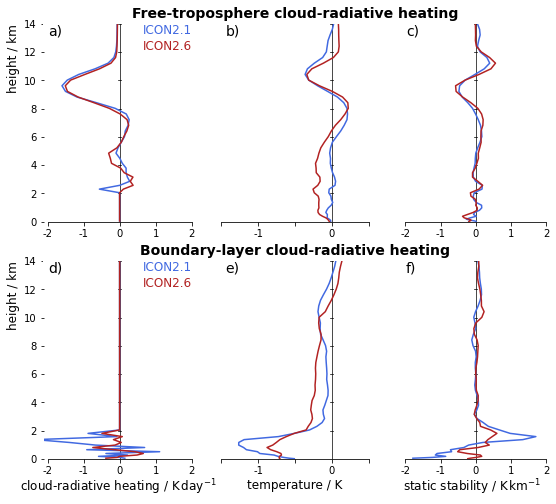

In [10]:
fig=plt.figure(figsize=(9,8))

# cloud-radiative heating in crh-on simulations (not the difference to the no-rad simulations)
ax=plt.subplot(2,3,1)
make_heightplot_var_up_w5km(var="crh", setup="ICON2.1 FTCRHONLY", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_w5km(var="crh", setup="ICON2.6 FTCRHONLY", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=4*0.02)
plt.xlim(-2.1,2)
ax.spines["bottom"].set_bounds(-2,2)
plt.xticks([-2,-1,0,1,2], ["-2", "-1", "0", "1", "2"], fontsize=10)
ax.xaxis.set_label_coords(0.5,-0.093)
ax.spines["left"].set_color("none")
ax.text(0.03, 1.0, "a)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)
plt.ylabel(r"height / km", size=12, loc="top")
plt.text(2, 14, "ICON2.1", color="royalblue", size=12, va="top", ha="right")
plt.text(2, 12.9, "ICON2.6", color="firebrick", size=12, va="top", ha="right")

ax=plt.subplot(2,3,4)
make_heightplot_var_up_w5km(var="crh", setup="ICON2.1 PBLCRHONLY", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_w5km(var="crh", setup="ICON2.6 PBLCRHONLY", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=4*0.02)
plt.xlim(-2.1,2)
ax.spines["bottom"].set_bounds(-2,2)
plt.xticks([-2,-1,0,1,2], ["-2", "-1", "0", "1", "2"], fontsize=10)
plt.xlabel(r"cloud-radiative heating / K$\,$day$^{-1}$", size=12)
ax.xaxis.set_label_coords(0.5,-0.093)
ax.spines["left"].set_color("none")
ax.text(0.03, 1.0, "d)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)
plt.ylabel(r"height / km", size=12, loc="top")
plt.text(2, 14, "ICON2.1", color="royalblue", size=12, va="top", ha="right")
plt.text(2, 12.9, "ICON2.6", color="firebrick", size=12, va="top", ha="right")

# changes in temperature
ax=plt.subplot(2,3,2)
make_heightplot_var_up_diff2norad_w5km(var="temp", setup1="ICON2.1 FTCRHONLY", setup2="ICON2.1 NORAD", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_diff2norad_w5km(var="temp", setup1="ICON2.6 FTCRHONLY", setup2="ICON2.6 NORAD", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=2.0*0.02)
plt.xlim(-1.5,0.5)
ax.spines["bottom"].set_bounds(-1.5,0.5)
plt.xticks([-1.5,-1,-0.5,0,0.5], ["", "-1", "", "0", ""], fontsize=10)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.spines["left"].set_color("none")
plt.yticks([], fontsize=10) 
ax.text(0.03, 1.0, "b)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)
plt.title("Free-troposphere cloud-radiative heating", size=14, weight="bold")

ax=plt.subplot(2,3,5)
make_heightplot_var_up_diff2norad_w5km(var="temp", setup1="ICON2.1 PBLCRHONLY", setup2="ICON2.1 NORAD", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_diff2norad_w5km(var="temp", setup1="ICON2.6 PBLCRHONLY", setup2="ICON2.6 NORAD", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=2.0*0.02)
plt.xlim(-1.5,0.5)
ax.spines["bottom"].set_bounds(-1.5,0.5)
plt.xticks([-1.5,-1,-0.5,0,0.5], ["", "-1", "", "0", ""], fontsize=10)
plt.xlabel(r"temperature / K", size=12)
ax.xaxis.set_label_coords(0.5,-0.1)
ax.spines["left"].set_color("none")
plt.yticks([], fontsize=10) 
ax.text(0.03, 1.0, "e)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)
plt.title("Boundary-layer cloud-radiative heating", size=14, weight="bold")


# static stability changes
ax=plt.subplot(2,3,3) 
make_heightplot_var_up_diff2norad_w5km(var="stab", setup1="ICON2.1 FTCRHONLY", setup2="ICON2.1 NORAD", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_diff2norad_w5km(var="stab", setup1="ICON2.6 FTCRHONLY", setup2="ICON2.6 NORAD", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=4*0.02)
plt.xlim(-2.2,2)
ax.spines["bottom"].set_bounds(-2,2)
plt.xticks([-2,-1,0,1,2], ["-2", "-1", "0", "1", "2"], fontsize=10)
plt.yticks([], fontsize=10) 
ax.xaxis.set_label_coords(0.5,-0.093)
ax.text(0.05, 1.0, "c)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)

ax=plt.subplot(2,3,6) 
make_heightplot_var_up_diff2norad_w5km(var="stab", setup1="ICON2.1 PBLCRHONLY", setup2="ICON2.1 NORAD", timeslice=[20,26], color="royalblue")
make_heightplot_var_up_diff2norad_w5km(var="stab", setup1="ICON2.6 PBLCRHONLY", setup2="ICON2.6 NORAD", timeslice=[20,26], color="firebrick")
make_niceaxes(ax, ticklength=4*0.02)
plt.xlim(-2.2,2)
ax.spines["bottom"].set_bounds(-2,2)
plt.xticks([-2,-1,0,1,2], ["-2", "-1", "0", "1", "2"], fontsize=10)
plt.xlabel(r"static stability / K$\,$km$^{-1}$", size=12) 
plt.yticks([], fontsize=10) 
ax.xaxis.set_label_coords(0.5,-0.093)
ax.text(0.05, 1.0, "f)", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", size=14)


plt.subplots_adjust(wspace=0.2)
plt.savefig("figure_supp_stability_ftcrh_pblcrh.pdf")